<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/ML-2024/blob/main/LSTM_Lightning_toyDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
pip install torch torchvision torchaudio pytorch-lightning seaborn numpy matplotlib

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 31.0 K | train
1 | fc        | Linear  | 51     | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
31.1 K    Trainable params
0         Non-trainable params
31.1 K    Total params
0.124     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([58])) that is different to the input size (torch.Size([58, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([62])) that is different to the input size (torch.Size([62, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.4679518938064575     │
└───────────────────────────┴───────────────────────────┘

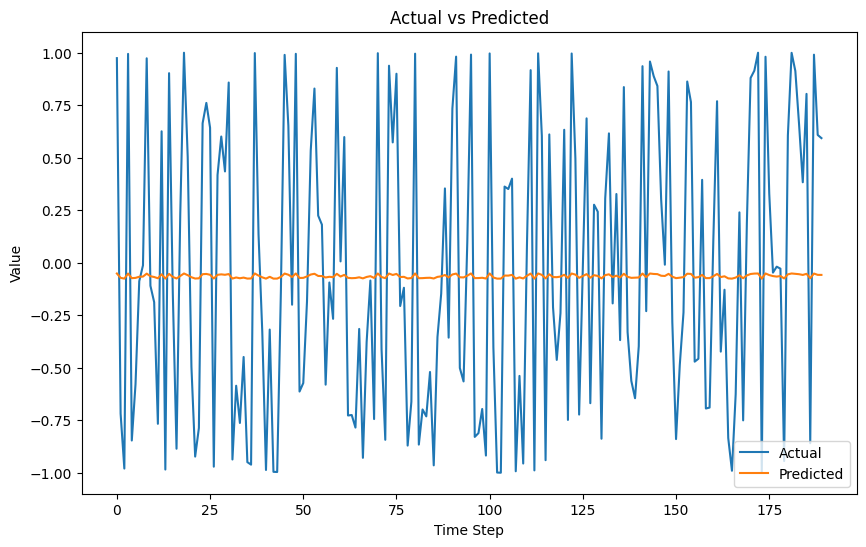

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset

# Generate sin(x) data
def generate_sin_data(seq_length, num_samples):
    x = np.linspace(0, 10 * np.pi, num_samples)
    y = np.sin(x)
    data = []
    for i in range(len(y) - seq_length):
        data.append(y[i:i + seq_length + 1])
    data = np.array(data)
    return data

# Prepare data
seq_length = 50
num_samples = 1000
data = generate_sin_data(seq_length, num_samples)

# Split data into train, validation, and test sets
train_size = int(0.6 * len(data))
val_size = int(0.2 * len(data))
test_size = len(data) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(data, [train_size, val_size, test_size])

# Create DataLoaders
def create_dataloader(data, seq_length, batch_size):
    X = torch.tensor(np.array([d[:-1] for d in data]), dtype=torch.float32).unsqueeze(-1)  # Add an extra dimension for input_size
    y = torch.tensor(np.array([d[-1] for d in data]), dtype=torch.float32)
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

batch_size = 64
train_loader = create_dataloader(train_data, seq_length, batch_size)
val_loader = create_dataloader(val_data, seq_length, batch_size)
test_loader = create_dataloader(test_data, seq_length, batch_size)

# Define LSTM model
class LSTMModel(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

# Initialize model
input_size = 1
hidden_size = 50
output_size = 1
num_layers = 2
model = LSTMModel(input_size, hidden_size, output_size, num_layers)

# Train the model
trainer = pl.Trainer(max_epochs=10, accelerator='gpu' if torch.cuda.is_available() else 'cpu', devices=1 if torch.cuda.is_available() else None)
trainer.fit(model, train_loader, val_loader)

# Test the model
trainer.test(model, test_loader)

# Visualize results
def visualize_results(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for x, y in test_loader:
            y_hat = model(x)
            predictions.append(y_hat.cpu().numpy().flatten())  # Flatten the predictions
            actuals.append(y.cpu().numpy())
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=np.arange(len(actuals)), y=actuals, label='Actual')
    sns.lineplot(x=np.arange(len(predictions)), y=predictions, label='Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted')
    plt.show()

visualize_results(model, test_loader)

Train data shape: (950, 51)
Validation data shape: (950, 51)
Test data shape: (950, 51)


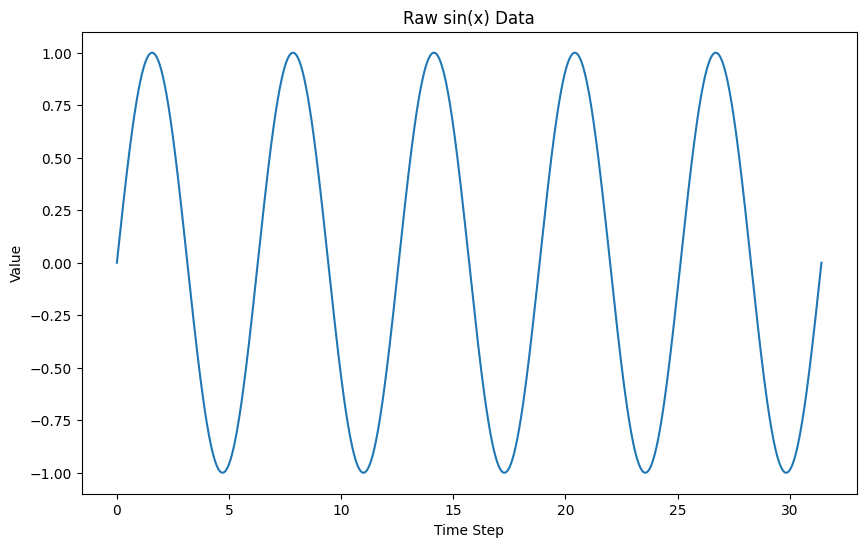

In [13]:
# Inspect data shapes and samples
print("Train data shape:", train_data.dataset.shape)
print("Validation data shape:", val_data.dataset.shape)
print("Test data shape:", test_data.dataset.shape)

# Plot raw sin(x) data
x = np.linspace(0, 10 * np.pi, num_samples)
y = np.sin(x)
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title('Raw sin(x) Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.show()

In [14]:
# Initialize model
input_size = 1
hidden_size = 100  # Increased hidden size
output_size = 1
num_layers = 3  # Increased number of layers
model = LSTMModel(input_size, hidden_size, output_size, num_layers)

In [15]:
# Train the model
trainer = pl.Trainer(max_epochs=50, accelerator='gpu' if torch.cuda.is_available() else 'cpu', devices=1 if torch.cuda.is_available() else None)
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 202 K  | train
1 | fc        | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
202 K     Trainable params
0         Non-trainable params
202 K     Total params
0.812     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([58])) that is different to the input size (torch.Size([58, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([62])) that is different to the input size (torch.Size([62, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [16]:
# Define LSTM model
class LSTMModel(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)  # Adjusted learning rate

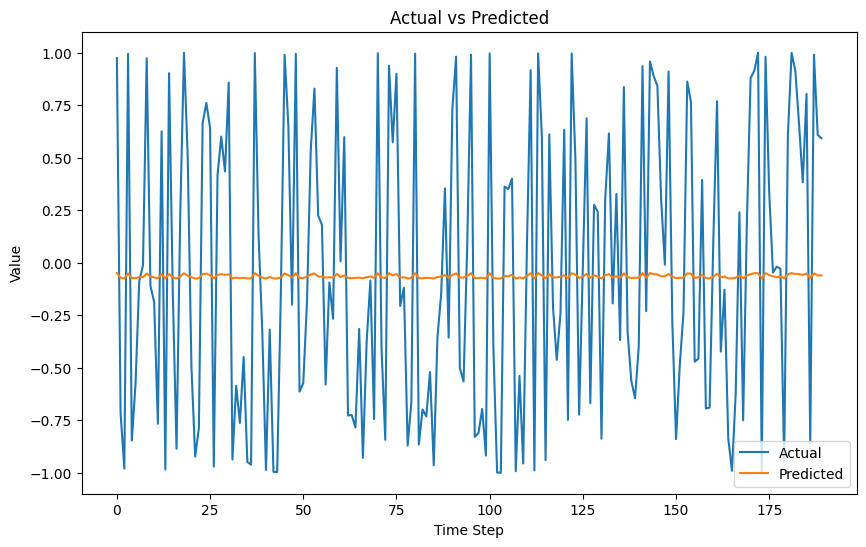

In [17]:
# Visualize results
def visualize_results(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for x, y in test_loader:
            y_hat = model(x)
            predictions.append(y_hat.cpu().numpy().flatten())  # Flatten the predictions
            actuals.append(y.cpu().numpy())
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=np.arange(len(actuals)), y=actuals, label='Actual')
    sns.lineplot(x=np.arange(len(predictions)), y=predictions, label='Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted')
    plt.show()

visualize_results(model, test_loader)